Accuracy: 0.8648648648648649
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.50      0.67         8
           2       0.40      0.67      0.50         3

    accuracy                           0.86        37
   macro avg       0.78      0.72      0.71        37
weighted avg       0.90      0.86      0.86        37



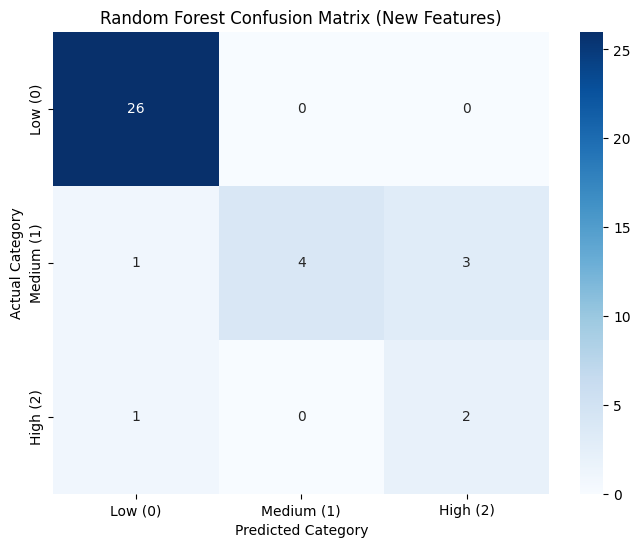


--- Sample Prediction ---
Sample Input: total_balls_faced = 40, total_runs = 55, run_rate_per_ball = 1.38


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# --- 1. Load Data ---
# NOTE: The script assumes that the file 'ODI Cricket Data new.csv' is available.
try:
    df = pd.read_csv('ODI Cricket Data new.csv')
except FileNotFoundError:
    print("Error: 'ODI Cricket Data new.csv' not found. Please check the file path.")
    exit()

# --- 2. Data Preprocessing and Feature Engineering ---
# Convert 'strike_rate' to numeric, coercing errors to NaN
df['strike_rate'] = pd.to_numeric(df['strike_rate'], errors='coerce')

# Drop rows where 'strike_rate' is NaN
df.dropna(subset=['strike_rate'], inplace=True)

# Feature Engineering: Add a calculated ratio feature
df['run_rate_per_ball'] = df['total_runs'] / df['total_balls_faced']

def categorize_strike_rate(sr):
  """
  Categorizes the strike rate into Low (0), Medium (1), or High (2).
  """
  if sr < 70:
    return 0  # Low
  elif sr < 120:
    return 1  # Medium
  else:
    return 2  # High

df['sr_category'] = df['strike_rate'].apply(categorize_strike_rate)

# Define features and target variable - NOW INCLUDING THE NEW FEATURE
features = ['total_balls_faced', 'total_runs', 'run_rate_per_ball']
X = df[features]
y = df['sr_category']

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 3.1. Handle Imbalanced Data using SMOTE (Less Aggressive Strategy) ---
# We will target a less aggressive balance (70 samples for classes 1 and 2,
# keeping the original 105 for class 0) to reduce noise from synthetic data.
sampling_strategy = {0: 105, 1: 70, 2: 70}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# --- 4. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------------------------
# --- 5. Train Random Forest Model with Best Parameters and New Feature ---
# ----------------------------------------------------------------------

# Using the best parameters found in the previous tuning step, now with the new feature
rf_model = RandomForestClassifier(
    n_estimators=50,             # Best parameter
    max_depth=15,                # Best parameter
    min_samples_split=2,         # Best parameter
    min_samples_leaf=1,          # Best parameter
    random_state=42,
    class_weight='balanced'
)


rf_model.fit(X_train_scaled, y_train_resampled)

y_pred = rf_model.predict(X_test_scaled)
# ----------------------------------------------------------------------

# --- 6. Evaluate ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# --- 7. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low (0)', 'Medium (1)', 'High (2)'],
            yticklabels=['Low (0)', 'Medium (1)', 'High (2)'])
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Random Forest Confusion Matrix (New Features)")
plt.show()

# --- 8. Sample Prediction ---
sample = [[40, 55, 55/40]] # Example: 40 balls faced, 55 runs, Run Rate/Ball: 1.375
sample_scaled = scaler.transform(sample)
pred = rf_model.predict(sample_scaled)
categories = {0: 'Low (SR < 70)', 1: 'Medium (70 <= SR < 120)', 2: 'High (SR >= 120)'}

print("\n--- Sample Prediction ---")
print(f"Sample Input: total_balls_faced = {sample[0][0]}, total_runs = {sample[0][1]}, run_rate_per_ball = {sample[0][2]:.2f}")


In [ ]:
!pip install imbalanced-learn

/tmp/ipython-input-316880630.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Actual_Category', data=results_df, palette='viridis', order=categories.values())
/tmp/ipython-input-316880630.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predicted_Category', data=results_df, palette='magma', order=categories.values())


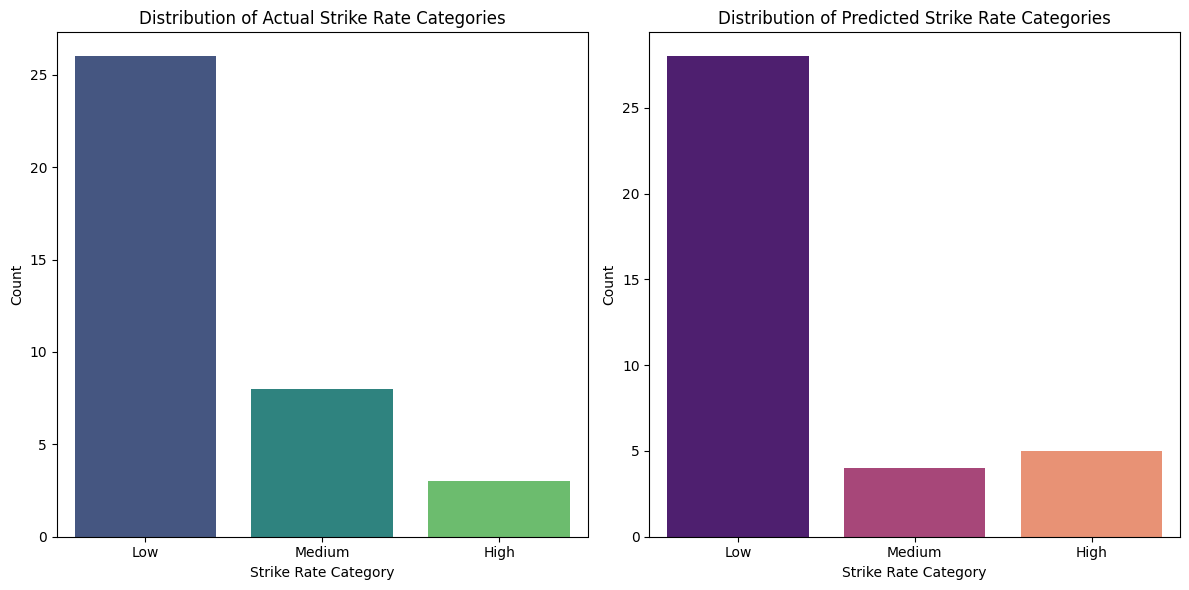

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Map numerical categories back to their labels for better readability on the plot
categories = {0: 'Low', 1: 'Medium', 2: 'High'}
results_df['Actual_Category'] = results_df['Actual'].map(categories)
results_df['Predicted_Category'] = results_df['Predicted'].map(categories)

plt.figure(figsize=(12, 6))

# Plot for Actual Categories
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.countplot(x='Actual_Category', data=results_df, palette='viridis', order=categories.values())
plt.title('Distribution of Actual Strike Rate Categories')
plt.xlabel('Strike Rate Category')
plt.ylabel('Count')

# Plot for Predicted Categories
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.countplot(x='Predicted_Category', data=results_df, palette='magma', order=categories.values())
plt.title('Distribution of Predicted Strike Rate Categories')
plt.xlabel('Strike Rate Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()